In [1]:
import os, pandas as pd, numpy as np
import ROOT
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from ROOT import TCanvas, TH1D
sns.set()

Welcome to JupyROOT 6.22/02


In [2]:
def create_track_list(tfile_tdaq):
    tfile_path = '/nfs/dust/fhlabs/group/BL4S/data/DESYChain/ConvertedData/' + str(tfile_tdaq) + '.root'
    data_run = ROOT.TFile(tfile_path)
    
    reco_tree = data_run.Get('RECOdata')
   
    '''
    micromega1x= -10.564471784019508
    micromega2x= -0.025884502340847576
    micromega3y= -11.74195086475566
    mimosa0x= 0.08463667999269381
    mimosa0y= -0.056565280079979845
    mimosa1x= -0.06449192869238878
    mimosa1y= -0.07193527449474807
    mimosa2x= 0.09808760125634848
    mimosa2y= -0.004454130628000803
    dwc0x= 0.02162774732829503
    dwc0y= -0.135752433620644
    '''
    micromega1x= 0
    micromega2x= 0
    micromega3y= 0
    mimosa0x= 0.08463667999269381
    mimosa0y= -0.056565280079979845
    mimosa1x= -0.06449192869238878
    mimosa1y= -0.07193527449474807
    mimosa2x= 0.09808760125634848
    mimosa2y= -0.004454130628000803
    dwc0x= 0
    dwc0y= 0

    counter = 0
    track_list = []
    mimosa_list = []
    
    for event in reco_tree:
        mimosa_track = []
        mimosa_track.append(list(zip([x-mimosa0x for x in event.Mimosa0_xPosition], [x-mimosa0y for x in event.Mimosa0_yPosition])))
        mimosa_track.append(list(zip([x-mimosa1x for x in event.Mimosa1_xPosition], [x-mimosa1y for x in event.Mimosa1_yPosition])))
        mimosa_track.append(list(zip([x-mimosa2x for x in event.Mimosa2_xPosition], [x-mimosa2y for x in event.Mimosa2_yPosition])))
        mimosa_list.append(mimosa_track)
        '''
        if (len(event.Chamber2_position) == 0 or 
            len(event.Mimosa0_xPosition) == 0 or len(event.Mimosa1_xPosition) == 0 or 
            len(event.Mimosa2_xPosition) == 0 or len(event.DWC0_xPosition) == 0 or 
            len(event.Chamber3_position) == 0 or len(event.DWC0_yPosition) == 0 or 
            len(event.Chamber1_position) == 0):
            counter += 1
            continue
        '''


        track = []
        track.append(list(zip([x-mimosa0x for x in event.Mimosa0_xPosition], [x-mimosa0y for x in event.Mimosa0_yPosition])))
        track.append(list(zip([x-mimosa1x for x in event.Mimosa1_xPosition], [x-mimosa1y for x in event.Mimosa1_yPosition])))
        track.append(list(zip([x-mimosa2x for x in event.Mimosa2_xPosition], [x-mimosa2y for x in event.Mimosa2_yPosition])))

        track.append(list(zip([x-dwc0x for x in event.DWC0_xPosition], [x-dwc0y for x in event.DWC0_yPosition])))
        #track.append(list(zip([x-dwc1x for x in event.DWC1_xPosition], [x-dwc1y for x in event.DWC1_yPosition])))

        track.append(list([x-micromega1x for x in event.Chamber1_position]))
        track.append(list([x-micromega2x for x in event.Chamber2_position]))
        track.append(list([x-micromega3y for x in event.Chamber3_position]))
        track.append(counter)
        track_list.append(track)

        counter += 1
        
    return track_list, mimosa_list

def pre_magnet_track(track_list, z_vals, event=0):
    zs = np.array([[0,8.5,16]])
    min_error = 100
    for (x1, y1) in track_list[event][0]:
        for (x2, y2) in track_list[event][1]:
            for (x3, y3) in track_list[event][2]:
                X = np.array([[x1, y1, z_vals[0]], [x2,y2, z_vals[1]], [x3,y3,z_vals[2]]])
                X_mean = X.mean(axis=0)
                uu, dd, vv = np.linalg.svd(X - X_mean)
                linepts = vv[0] * np.mgrid[-7:7:2j][:, np.newaxis]
                linepts += X_mean
                direction = linepts[1]-linepts[0]
                z_t = (z_vals-linepts[0][2])/direction[2]
                points = np.concatenate((np.reshape(linepts[0, 0:2], (2,1)) + (z_t * np.reshape(direction[0:2], (2,1))), zs))
                error = np.mean(np.square(points.T - X))
                if error < min_error:
                    best_track = np.array([[x1,x2,x3],[y1,y2,y3], [0,8.5,16]])
                    min_error = error
                
    print(min_error)
    print(best_track)  

In [3]:
track_list, mimosa_list = create_track_list(1572179299)

In [7]:
errors = []
for event in range(len(track_list)):
    min_error = 100
    min_i = 0
    min_j = 0
    min_k = 0
    #Aligning Mimosa1
    for i, hits1 in enumerate(mimosa_list[event][0]):
        for j, hits3 in enumerate(mimosa_list[event][2]):
            z = np.polyfit(np.array([0., 16.]), np.array([hits1[0], hits3[0]]), 1)
            pred_mimosa1 = z[0]*8.5 + z[1]
            for k, hits2 in enumerate(mimosa_list[event][1]):
                error = hits2[0]-pred_mimosa1
                if np.abs(error) < np.abs(min_error):
                    min_error = error
                    min_i = i
                    min_j = j
                    min_k = k
    print(event)
    errors.append(min_error)
    if event > 2000:
        break

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1996
1997
1998
1999
2000
2001


In [ ]:
plt.figure(figsize=(14,10))
plt.scatter(0*np.ones((1, len(mimosa_list[0][0]))), np.array(mimosa_list[0][0])[:, 0], c='r')
plt.scatter(8.5*np.ones((1, len(mimosa_list[0][1]))), np.array(mimosa_list[0][1])[:, 0], c='g')
plt.scatter(16*np.ones((1, len(mimosa_list[0][2]))), np.array(mimosa_list[0][2])[:, 0], c='b')

In [ ]:
for i in mimosa_list[event][0][0]:
    print(i)

In [ ]:
track_list[event][0]

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   1.,   1.,
          1.,   1.,   0.,   2.,   2.,   2.,   0.,   1.,   0.,   1.,   0.,
          1.,   0.,   2.,   1.,   0.,   0.,   2.,   1.,   3.,   3.,   4.,
          3.,   3.,   4.,   4.,   5.,   6.,  11.,   6.,   6.,   9.,  10.,
         12.,  22.,  37.,  63., 174., 874., 233.,  95.,  48.,  35.,  19.,
         19.,  11.,  11.,   8.,  11.,   8.,   7.,   4.,   9.,   5.,   9.,
          4.,   3.,   4.,   4.,   1.,   2.,  10.,   8.,   2.,   1.,   2.,
          0.,   1.,   1.,   0.,   0.,   0.,   1.,   0.,   2.,   0.,   1.,
          1.,   1.,   0.,   1.,   2.,   1.,   0.,   1.,   0.,   0.,   2.,
          1.]),
 array([-0.33103809, -0.32436636, -0.31769464, -0.31102291, -0.30435119,
        -0.29767946, -0.29100774, -0.28433601, -0.27766429, -0.27099256,
        -0.26432084, -0.25764911, -0.25097739, -0.24430566, -0.23763394,
        -0.23096221, -0.22429049, -0.21761876, -0.21094704, -0.20427531,
        -0.19760359, -0.19

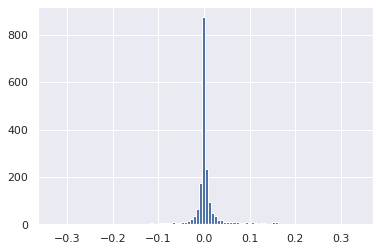

In [36]:
errors_fixed = [x for x in errors if x != 100]
plt.hist(np.array(errors_fixed)[abs(errors_fixed - np.mean(errors_fixed)) < 3 * np.std(errors_fixed)], bins= 100)

In [20]:
max([x for x in errors if x != 100])

1.636036910606399

In [32]:
errors_fixed = [x for x in errors if x != 100]
np.max(np.array(errors_fixed)[abs(errors_fixed - np.mean(errors_fixed)) < 3 * np.std(errors_fixed)])

0.33613441060639915

In [29]:
np.std(errors)

20.385300968421767

In [37]:
np.mean(np.array(errors_fixed)[abs(errors_fixed - np.mean(errors_fixed)) < 3 * np.std(errors_fixed)])

0.003884148733630228